# Estimating Oreintation Given STA

In [23]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils import RFutils
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3_sca=3.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))

LGN cells: 214
V1 cells: 1491


In [4]:
V1_cell_key = [cell_key[i] for i in V1_idx]
L23_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L2/3']
L23_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L2/3']
L4_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L4']
L4_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L4']

In [5]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=V1_idx)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 18.141195058822632 sec


In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)

stim_dims = [1, 60, 60, 1]
num_lags = 12
L = 60


In [7]:
NC = data[0]['robs'].shape[1]
print('Number of cells', NC)

Number of cells 1491


In [8]:
NT = data.NT
print('Number of time points', NT)

Number of time points 170000


In [43]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[V1_idx], y_pos[V1_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (1491, 2)


## GLM

In [10]:
Treg = 1
Xreg = 10000.0
L1reg = 1.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=1, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 

In [20]:
glms = []
for i in range(NC):
    j = V1_idx[i]
    cell_data = SimCloudData(file_name=out_file, down_sample=2, cell_idx=[j])
    glm_i = NDN( layer_list=[glm_par], loss_type='poisson')
    fit_lbfgs(glm_i, cell_data[:], verbose=False)
    glms.append(glm_i)
    print("GLM computed for cell",i)

GLM computed for cell 0
GLM computed for cell 1
GLM computed for cell 2
GLM computed for cell 3
GLM computed for cell 4
GLM computed for cell 5
GLM computed for cell 6
GLM computed for cell 7
GLM computed for cell 8
GLM computed for cell 9
GLM computed for cell 10
GLM computed for cell 11
GLM computed for cell 12
GLM computed for cell 13
GLM computed for cell 14
GLM computed for cell 15
GLM computed for cell 16
GLM computed for cell 17
GLM computed for cell 18
GLM computed for cell 19
GLM computed for cell 20
GLM computed for cell 21
GLM computed for cell 22
GLM computed for cell 23
GLM computed for cell 24
GLM computed for cell 25
GLM computed for cell 26
GLM computed for cell 27
GLM computed for cell 28
GLM computed for cell 29
GLM computed for cell 30
GLM computed for cell 31
GLM computed for cell 32
GLM computed for cell 33
GLM computed for cell 34
GLM computed for cell 35
GLM computed for cell 36
GLM computed for cell 37
GLM computed for cell 38
GLM computed for cell 39
GLM comput

In [26]:
ex = glms[0].get_weights()[:,:,:,0]
ex.shape

(60, 60, 12)

## Orientation

In [28]:
thetas = np.zeros(NC)
osis = np.zeros(NC)
for cc in range(NC):
    thetas[cc], osis[cc] = RFutils.filter_orientation_stats( klist=[glms[cc].get_weights()[:,:,:,0]], to_plot=False)

In [33]:
print(thetas.shape)
print(osis.shape)

(1491,)
(1491,)


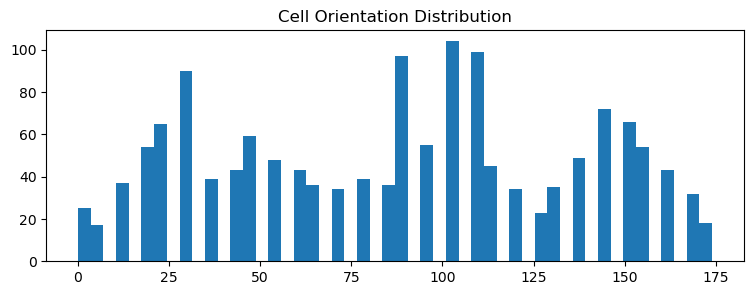

In [32]:
plt.figure(figsize=(9,3))
plt.hist(thetas ,bins=50)
plt.title('Cell Orientation Distribution')
plt.show()

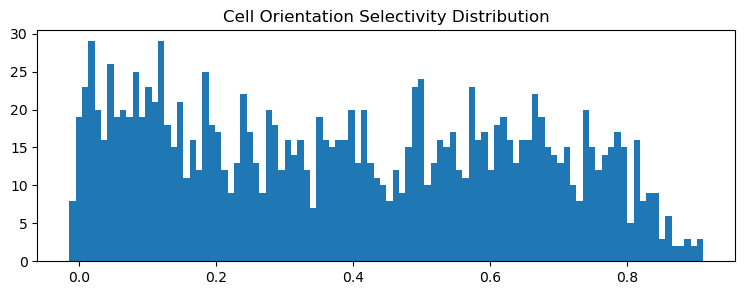

In [38]:
plt.figure(figsize=(9,3))
plt.hist(osis ,bins=100)
plt.title('Cell Orientation Selectivity Distribution')
plt.show()

In [50]:
print("Layer 4 exc avg osi:", np.mean(osis[L4_exc_idx]))
print("Layer 4 inh avg osi:", np.mean(osis[L4_inh_idx]))
print("Layer 2/3 exc avg osi:", np.mean(osis[L23_exc_idx]))
print("Layer 2/3 exc avg osi:", np.mean(osis[L23_inh_idx]))

Layer 4 exc avg osi: 0.5355715618620643
Layer 4 inh avg osi: 0.5989665605591321
Layer 2/3 exc avg osi: 0.22250342115048494
Layer 2/3 exc avg osi: 0.17864878189841912


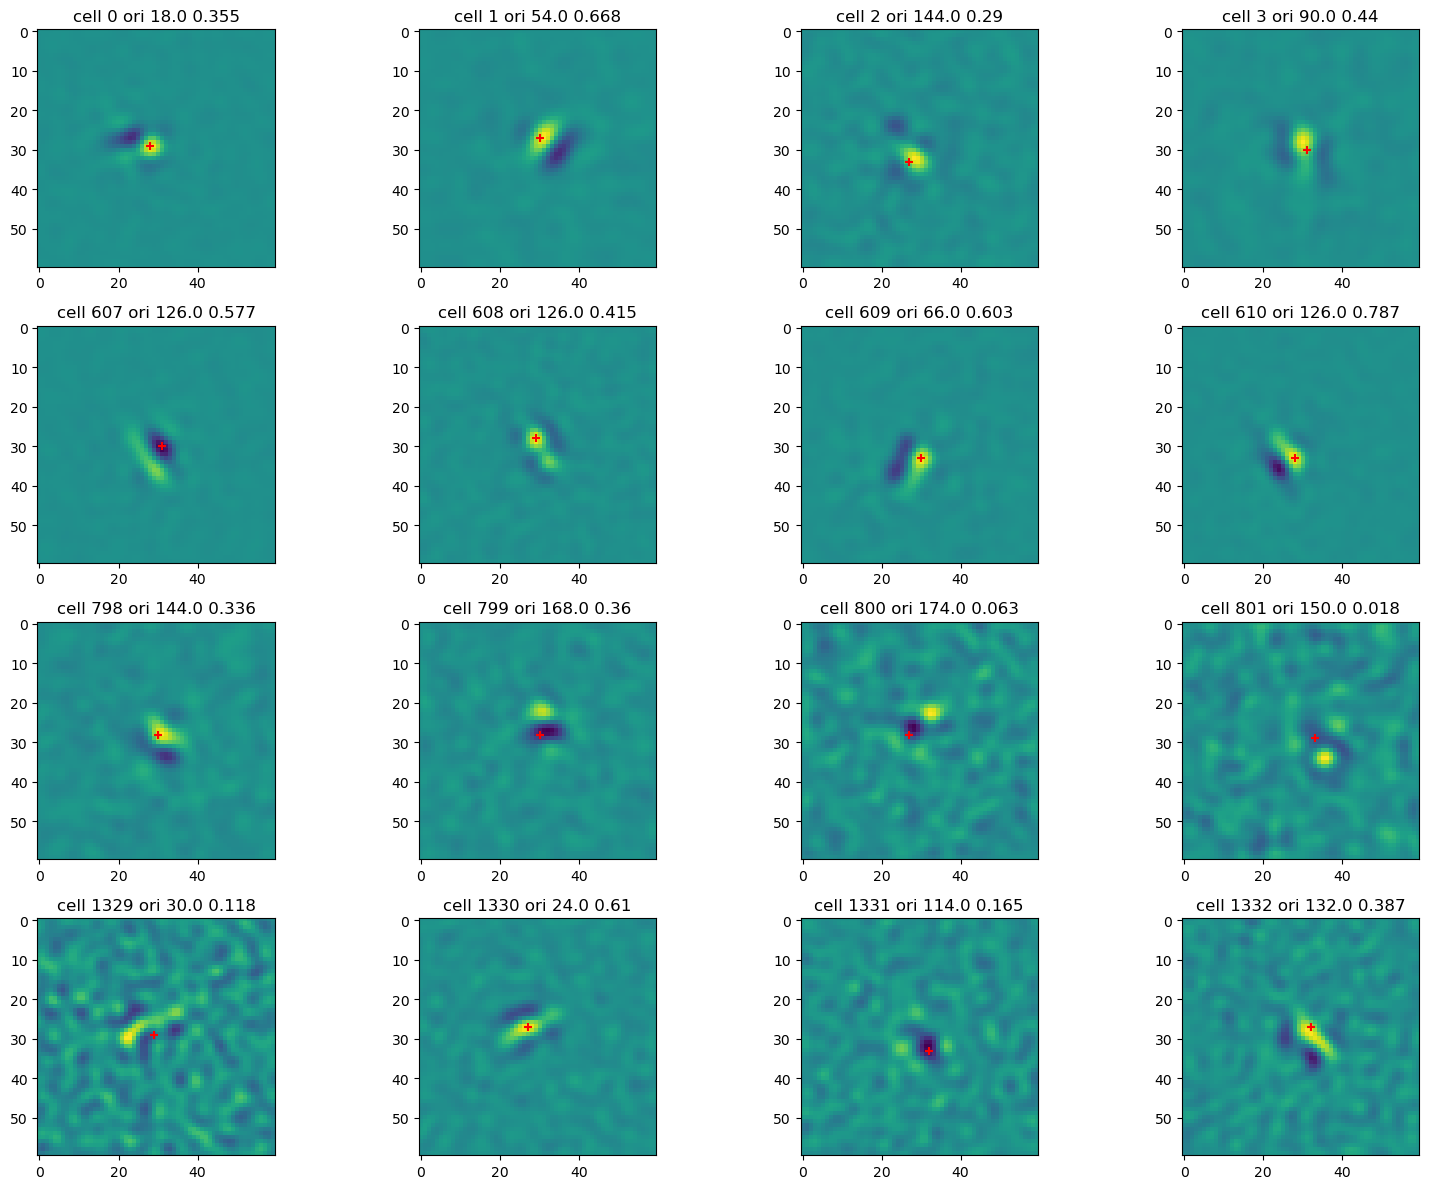

In [48]:
ss(4,4)
k = 1

for i in range(4):
    plt.subplot(4,4,k)
    l = L4_exc_idx[i]
    imagesc(glms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1
for i in range(4):
    plt.subplot(4,4,k)
    l = L4_inh_idx[i]
    imagesc(glms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1
for i in range(4):
    plt.subplot(4,4,k)
    l = L23_exc_idx[i+4]
    imagesc(glms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1
for i in range(4):
    plt.subplot(4,4,k)
    l = L23_inh_idx[i]
    imagesc(glms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1

plt.tight_layout()
plt.show()